In [4]:
from numpy import *
import matplotlib.pyplot as plt 
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import preprocessing
import pandas as pd

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#df = pd.read_csv("NoSqli_Dataset.csv")
df = pd.read_csv("/content/drive/MyDrive/Thesis Resources/dataset/NoSql_Injection/NoSqli_Dataset.csv")
df.head()

,Feature0,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,ClassLabel
0,0,0,0,1,1,0,0,0,0,0,0
1,1,1,0,1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0


In [7]:

X = df.drop(['ClassLabel'],axis='columns')
Y = df['ClassLabel']

In [8]:
Y.value_counts()

0    801
1    203
Name: ClassLabel, dtype: int64

In [9]:
X.head(2)

,Feature0,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9
0,0,0,0,1,1,0,0,0,0,0
1,1,1,0,1,0,0,0,0,0,0


In [10]:
Y.head(5)

0    0
1    1
2    0
3    0
4    0
Name: ClassLabel, dtype: int64

# Evaluation of Best Classification Model Using GridSearchCV(with handling imbalanced data)

In [11]:
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix , classification_report

model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',class_weight='balanced'),
        'params' : {
            'C': [1,10,20],
            'kernel': ['rbf','linear','poly']
        }  
    },
    'decision_tree': {
        'model': tree.DecisionTreeClassifier(class_weight='balanced'),
        'params' : {
            'criterion':["gini","entropy"],
            'max_depth':[1,2,3,4,5,6,7,None]
        }
    },
    'Adaboost':{
        'model':AdaBoostClassifier(base_estimator = tree.DecisionTreeClassifier(random_state = 11, max_features = "auto",max_depth = None,class_weight='balanced')),
        'params':{
              'base_estimator__criterion' : ["gini", "entropy"],
              'base_estimator__splitter' :   ["best", "random"],
              'n_estimators': [1, 2]
             }
    },

    'random_forest': {
        'model': RandomForestClassifier(class_weight = 'balanced'),
        'params' : {
            'n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto',class_weight = 'balanced'),
        'params': {
            'C': [1,5,10]
        }
    },
    'Naive_Bayes:BernoulliNB':{
        'model':BernoulliNB(),
        'params':{
            'alpha': [0.01, 0.1, 0.5, 1.0, 10.0],
        }
    },
}

In [12]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import ClusterCentroids,NearMiss, RandomUnderSampler
from imblearn.combine import SMOTEENN,SMOTETomek
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV



#this method should be updated with more ML models
def benchmark(sampling_type,x,y):
    #lr = LogisticRegression(penalty = 'l2')
    #param_grid = {'C':[0.01,0.1,1,10]}
    scores = []

    target_names = ['Not Malicious', 'Malicious']
    ConfusionMatrix={}

    for model_name, mp in model_params.items():
        grid =  GridSearchCV(estimator=mp['model'],param_grid= mp['params'],scoring='accuracy', cv=10,n_jobs=-1,verbose=2)
        grid = grid.fit(x, y)
        y_pred=grid.best_estimator_.predict(x)
        print('-------------------------------------------')
        print(model_name.upper())  
        print('-------------------------------------------')
        report=classification_report(y, y_pred, target_names=target_names,output_dict=True)
        print(report)
        ConfusionMatrix[model_name]  =  confusion_matrix(y, y_pred)
        
        macro_precision =  report['macro avg']['precision'] 
        macro_recall = report['macro avg']['recall']    
        macro_f1 = report['macro avg']['f1-score']    
        accuracy = report['accuracy']

        
        # print("precision: ")
        # print(macro_precision)
        # print("recall: ")
        # print(macro_recall)
        # print("f1-score: ")
        # print(macro_f1)
        # print("accuracy: ")
        # print(accuracy)
      
        
        scores.append({
            'sampling_type':sampling_type,
            'model': model_name.upper(),
            'best_score': grid.best_score_,
            'precision':macro_precision,
            'recall':macro_recall,
            'f1_score':macro_f1,
            'best_params': grid.best_params_,    
        })
    
        #gs = GridSearchCV(estimator=lr, param_grid=param_grid, scoring='accuracy', cv=10, verbose=2)
        #gs = gs.fit(X.values,Y.values.ravel())
    return scores

def transform(transformer,X,Y):
    print("Transforming {}".format(transformer.__class__.__name__))
    X_resampled,Y_resampled = transformer.fit_sample(X.values,Y.values.ravel())
    return transformer.__class__.__name__,pd.DataFrame(X_resampled), pd.DataFrame(Y_resampled)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Apply transformations to dataset

In [13]:
datasets = []
datasets.append(("base",X,Y))
datasets.append(transform(SMOTE(n_jobs=-1),X,Y))
datasets.append(transform(RandomOverSampler(),X,Y))
datasets.append(transform(NearMiss(n_jobs=-1),X,Y))
datasets.append(transform(RandomUnderSampler(),X,Y))
datasets.append(transform(SMOTEENN(),X,Y))
datasets.append(transform(SMOTETomek(),X,Y))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Transforming SMOTE
Transforming RandomOverSampler
Transforming NearMiss


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Transforming RandomUnderSampler
Transforming SMOTEENN
Transforming SMOTETomek


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Determine best hyperparameters

In [14]:
benchmark_scores = []
for sample_type,X,Y in datasets:
    print('______________________________________________________________')
    print('{}'.format(sample_type))
    benchmark_scores = benchmark_scores + (benchmark(sample_type,X,Y))
    print('______________________________________________________________')



______________________________________________________________
base
Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
SVM
-------------------------------------------
{'Not Malicious': {'precision': 0.9634300126103404, 'recall': 0.9538077403245943, 'f1-score': 0.958594730238394, 'support': 801}, 'Malicious': {'precision': 0.8246445497630331, 'recall': 0.8571428571428571, 'f1-score': 0.8405797101449276, 'support': 203}, 'accuracy': 0.9342629482071713, 'macro avg': {'precision': 0.8940372811866868, 'recall': 0.9054752987337257, 'f1-score': 0.8995872201916608, 'support': 1004}, 'weighted avg': {'precision': 0.9353688084689028, 'recall': 0.9342629482071713, 'f1-score': 0.9347331275700935, 'support': 1004}}
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
DECISION_TREE
-------------------------------------------
{'Not Malicious': {'precision': 0.9698162729658792, 'recall': 0.9225967540574282, 'f1-score': 0.945617402431222, 'support': 801}, 'Malicious': {'precision': 0.743801652892562, 'recall': 0.8866995073891626, 'f1-score': 0.8089887640449438, 'support': 203}, 'accuracy': 0.9153386454183267, 'macro avg': {'precision': 0.8568089629292206, 'recall': 0.9046481307232954, 'f1-score': 0.8773030832380829, 'support': 1004}, 'weighted avg': {'precision': 0.9241180977916926, 'recall': 0.9153386454183267, 'f1-score': 0.917992289291367, 'support': 1004}}
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
ADABOOST
-------------------------------------------
{'Not Malicious': {'precision': 0.9695817490494296, 'recall': 0.9550561797752809, 'f1-score': 0.9622641509433961, 'support': 801}, 'Malicious': {'precision': 0.8325581395348837, 'recall': 0.8817733990147784, 'f1-score': 0.8564593301435407, 'support': 203}, 'accuracy': 0.9402390438247012, 'macro avg': {'precision': 0.9010699442921566, 'recall': 0.9184147893950296, 'f1-score': 0.9093617405434684, 'support': 1004}, 'weighted avg': {'precision': 0.9418767762093372, 'recall': 0.9402390438247012, 'f1-score': 0.9408713435505967, 'support': 1004}}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished


-------------------------------------------
RANDOM_FOREST
-------------------------------------------
{'Not Malicious': {'precision': 0.9650436953807741, 'recall': 0.9650436953807741, 'f1-score': 0.9650436953807741, 'support': 801}, 'Malicious': {'precision': 0.8620689655172413, 'recall': 0.8620689655172413, 'f1-score': 0.8620689655172413, 'support': 203}, 'accuracy': 0.9442231075697212, 'macro avg': {'precision': 0.9135563304490077, 'recall': 0.9135563304490077, 'f1-score': 0.9135563304490077, 'support': 1004}, 'weighted avg': {'precision': 0.9442231075697212, 'recall': 0.9442231075697212, 'f1-score': 0.9442231075697212, 'support': 1004}}
Fitting 10 folds for each of 3 candidates, totalling 30 fits
-------------------------------------------
LOGISTIC_REGRESSION
-------------------------------------------
{'Not Malicious': {'precision': 0.9730458221024259, 'recall': 0.9013732833957553, 'f1-score': 0.9358392741412831, 'support': 801}, 'Malicious': {'precision': 0.6984732824427481, 'reca

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
NAIVE_BAYES:BERNOULLINB
-------------------------------------------
{'Not Malicious': {'precision': 0.9459459459459459, 'recall': 0.9612983770287141, 'f1-score': 0.9535603715170278, 'support': 801}, 'Malicious': {'precision': 0.8368421052631579, 'recall': 0.7832512315270936, 'f1-score': 0.8091603053435116, 'support': 203}, 'accuracy': 0.9252988047808764, 'macro avg': {'precision': 0.8913940256045519, 'recall': 0.8722748042779038, 'f1-score': 0.8813603384302697, 'support': 1004}, 'weighted avg': {'precision': 0.9238861056485296, 'recall': 0.9252988047808764, 'f1-score': 0.9243639437946933, 'support': 1004}}
______________________________________________________________
______________________________________________________________
SMOTE
Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.3s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
SVM
-------------------------------------------
{'Not Malicious': {'precision': 0.8896969696969697, 'recall': 0.916354556803995, 'f1-score': 0.9028290282902829, 'support': 801}, 'Malicious': {'precision': 0.9137709137709138, 'recall': 0.8863920099875156, 'f1-score': 0.899873257287706, 'support': 801}, 'accuracy': 0.9013732833957553, 'macro avg': {'precision': 0.9017339417339417, 'recall': 0.9013732833957553, 'f1-score': 0.9013511427889944, 'support': 1602}, 'weighted avg': {'precision': 0.9017339417339417, 'recall': 0.9013732833957553, 'f1-score': 0.9013511427889944, 'support': 1602}}
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
DECISION_TREE
-------------------------------------------
{'Not Malicious': {'precision': 0.8821428571428571, 'recall': 0.9250936329588015, 'f1-score': 0.903107861060329, 'support': 801}, 'Malicious': {'precision': 0.9212598425196851, 'recall': 0.8764044943820225, 'f1-score': 0.8982725527831095, 'support': 801}, 'accuracy': 0.900749063670412, 'macro avg': {'precision': 0.9017013498312711, 'recall': 0.9007490636704121, 'f1-score': 0.9006902069217193, 'support': 1602}, 'weighted avg': {'precision': 0.901701349831271, 'recall': 0.900749063670412, 'f1-score': 0.9006902069217193, 'support': 1602}}
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.7s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
ADABOOST
-------------------------------------------
{'Not Malicious': {'precision': 0.8926417370325693, 'recall': 0.9238451935081149, 'f1-score': 0.9079754601226994, 'support': 801}, 'Malicious': {'precision': 0.9210866752910737, 'recall': 0.8888888888888888, 'f1-score': 0.9047013977128335, 'support': 801}, 'accuracy': 0.9063670411985019, 'macro avg': {'precision': 0.9068642061618215, 'recall': 0.9063670411985019, 'f1-score': 0.9063384289177665, 'support': 1602}, 'weighted avg': {'precision': 0.9068642061618214, 'recall': 0.9063670411985019, 'f1-score': 0.9063384289177664, 'support': 1602}}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.5s finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
RANDOM_FOREST
-------------------------------------------
{'Not Malicious': {'precision': 0.8926417370325693, 'recall': 0.9238451935081149, 'f1-score': 0.9079754601226994, 'support': 801}, 'Malicious': {'precision': 0.9210866752910737, 'recall': 0.8888888888888888, 'f1-score': 0.9047013977128335, 'support': 801}, 'accuracy': 0.9063670411985019, 'macro avg': {'precision': 0.9068642061618215, 'recall': 0.9063670411985019, 'f1-score': 0.9063384289177665, 'support': 1602}, 'weighted avg': {'precision': 0.9068642061618214, 'recall': 0.9063670411985019, 'f1-score': 0.9063384289177664, 'support': 1602}}
Fitting 10 folds for each of 3 candidates, totalling 30 fits
-------------------------------------------
LOGISTIC_REGRESSION
-------------------------------------------


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


{'Not Malicious': {'precision': 0.86810551558753, 'recall': 0.9038701622971286, 'f1-score': 0.8856269113149848, 'support': 801}, 'Malicious': {'precision': 0.8997395833333334, 'recall': 0.8626716604244694, 'f1-score': 0.8808158062460165, 'support': 801}, 'accuracy': 0.883270911360799, 'macro avg': {'precision': 0.8839225494604317, 'recall': 0.883270911360799, 'f1-score': 0.8832213587805007, 'support': 1602}, 'weighted avg': {'precision': 0.8839225494604316, 'recall': 0.883270911360799, 'f1-score': 0.8832213587805006, 'support': 1602}}
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
NAIVE_BAYES:BERNOULLINB
-------------------------------------------
{'Not Malicious': {'precision': 0.851808634772462, 'recall': 0.9113607990012484, 'f1-score': 0.8805790108564535, 'support': 801}, 'Malicious': {'precision': 0.9046979865771813, 'recall': 0.8414481897627965, 'f1-score': 0.871927554980595, 'support': 801}, 'accuracy': 0.8764044943820225, 'macro avg': {'precision': 0.8782533106748216, 'recall': 0.8764044943820224, 'f1-score': 0.8762532829185243, 'support': 1602}, 'weighted avg': {'precision': 0.8782533106748217, 'recall': 0.8764044943820225, 'f1-score': 0.8762532829185243, 'support': 1602}}
______________________________________________________________
______________________________________________________________
RandomOverSampler
Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.2s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
SVM
-------------------------------------------
{'Not Malicious': {'precision': 0.900355871886121, 'recall': 0.947565543071161, 'f1-score': 0.9233576642335767, 'support': 801}, 'Malicious': {'precision': 0.9446640316205533, 'recall': 0.8951310861423221, 'f1-score': 0.9192307692307692, 'support': 801}, 'accuracy': 0.9213483146067416, 'macro avg': {'precision': 0.9225099517533372, 'recall': 0.9213483146067416, 'f1-score': 0.9212942167321729, 'support': 1602}, 'weighted avg': {'precision': 0.9225099517533373, 'recall': 0.9213483146067416, 'f1-score': 0.921294216732173, 'support': 1602}}
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done 157 out of 160 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
DECISION_TREE
-------------------------------------------
{'Not Malicious': {'precision': 0.901060070671378, 'recall': 0.9550561797752809, 'f1-score': 0.9272727272727272, 'support': 801}, 'Malicious': {'precision': 0.952191235059761, 'recall': 0.8951310861423221, 'f1-score': 0.9227799227799227, 'support': 801}, 'accuracy': 0.9250936329588015, 'macro avg': {'precision': 0.9266256528655695, 'recall': 0.9250936329588015, 'f1-score': 0.925026325026325, 'support': 1602}, 'weighted avg': {'precision': 0.9266256528655694, 'recall': 0.9250936329588015, 'f1-score': 0.925026325026325, 'support': 1602}}
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.8s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
ADABOOST
-------------------------------------------
{'Not Malicious': {'precision': 0.901060070671378, 'recall': 0.9550561797752809, 'f1-score': 0.9272727272727272, 'support': 801}, 'Malicious': {'precision': 0.952191235059761, 'recall': 0.8951310861423221, 'f1-score': 0.9227799227799227, 'support': 801}, 'accuracy': 0.9250936329588015, 'macro avg': {'precision': 0.9266256528655695, 'recall': 0.9250936329588015, 'f1-score': 0.925026325026325, 'support': 1602}, 'weighted avg': {'precision': 0.9266256528655694, 'recall': 0.9250936329588015, 'f1-score': 0.925026325026325, 'support': 1602}}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.4s finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
RANDOM_FOREST
-------------------------------------------
{'Not Malicious': {'precision': 0.9008264462809917, 'recall': 0.9525593008739076, 'f1-score': 0.9259708737864079, 'support': 801}, 'Malicious': {'precision': 0.9496688741721855, 'recall': 0.8951310861423221, 'f1-score': 0.9215938303341902, 'support': 801}, 'accuracy': 0.9238451935081149, 'macro avg': {'precision': 0.9252476602265887, 'recall': 0.9238451935081149, 'f1-score': 0.923782352060299, 'support': 1602}, 'weighted avg': {'precision': 0.9252476602265887, 'recall': 0.9238451935081149, 'f1-score': 0.9237823520602989, 'support': 1602}}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
LOGISTIC_REGRESSION
-------------------------------------------
{'Not Malicious': {'precision': 0.9036295369211514, 'recall': 0.9013732833957553, 'f1-score': 0.9025, 'support': 801}, 'Malicious': {'precision': 0.9016189290161893, 'recall': 0.9038701622971286, 'f1-score': 0.9027431421446385, 'support': 801}, 'accuracy': 0.9026217228464419, 'macro avg': {'precision': 0.9026242329686704, 'recall': 0.9026217228464419, 'f1-score': 0.9026215710723192, 'support': 1602}, 'weighted avg': {'precision': 0.9026242329686703, 'recall': 0.9026217228464419, 'f1-score': 0.9026215710723193, 'support': 1602}}
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
NAIVE_BAYES:BERNOULLINB
-------------------------------------------
{'Not Malicious': {'precision': 0.8946078431372549, 'recall': 0.9113607990012484, 'f1-score': 0.9029066171923316, 'support': 801}, 'Malicious': {'precision': 0.9096692111959288, 'recall': 0.8926342072409488, 'f1-score': 0.9010712035286704, 'support': 801}, 'accuracy': 0.9019975031210986, 'macro avg': {'precision': 0.9021385271665918, 'recall': 0.9019975031210986, 'f1-score': 0.901988910360501, 'support': 1602}, 'weighted avg': {'precision': 0.9021385271665919, 'recall': 0.9019975031210986, 'f1-score': 0.901988910360501, 'support': 1602}}
______________________________________________________________
______________________________________________________________
NearMiss
Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.6s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
SVM
-------------------------------------------
{'Not Malicious': {'precision': 0.9035532994923858, 'recall': 0.8768472906403941, 'f1-score': 0.89, 'support': 203}, 'Malicious': {'precision': 0.8803827751196173, 'recall': 0.9064039408866995, 'f1-score': 0.8932038834951458, 'support': 203}, 'accuracy': 0.8916256157635468, 'macro avg': {'precision': 0.8919680373060015, 'recall': 0.8916256157635468, 'f1-score': 0.8916019417475729, 'support': 406}, 'weighted avg': {'precision': 0.8919680373060016, 'recall': 0.8916256157635468, 'f1-score': 0.8916019417475729, 'support': 406}}
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
DECISION_TREE
-------------------------------------------
{'Not Malicious': {'precision': 0.8598130841121495, 'recall': 0.9064039408866995, 'f1-score': 0.8824940047961631, 'support': 203}, 'Malicious': {'precision': 0.9010416666666666, 'recall': 0.8522167487684729, 'f1-score': 0.8759493670886076, 'support': 203}, 'accuracy': 0.8793103448275862, 'macro avg': {'precision': 0.8804273753894081, 'recall': 0.8793103448275862, 'f1-score': 0.8792216859423854, 'support': 406}, 'weighted avg': {'precision': 0.880427375389408, 'recall': 0.8793103448275862, 'f1-score': 0.8792216859423854, 'support': 406}}
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.6s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
ADABOOST
-------------------------------------------
{'Not Malicious': {'precision': 0.8916256157635468, 'recall': 0.8916256157635468, 'f1-score': 0.8916256157635468, 'support': 203}, 'Malicious': {'precision': 0.8916256157635468, 'recall': 0.8916256157635468, 'f1-score': 0.8916256157635468, 'support': 203}, 'accuracy': 0.8916256157635468, 'macro avg': {'precision': 0.8916256157635468, 'recall': 0.8916256157635468, 'f1-score': 0.8916256157635468, 'support': 406}, 'weighted avg': {'precision': 0.8916256157635468, 'recall': 0.8916256157635468, 'f1-score': 0.8916256157635468, 'support': 406}}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.4s finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


-------------------------------------------
RANDOM_FOREST
-------------------------------------------
{'Not Malicious': {'precision': 0.9035532994923858, 'recall': 0.8768472906403941, 'f1-score': 0.89, 'support': 203}, 'Malicious': {'precision': 0.8803827751196173, 'recall': 0.9064039408866995, 'f1-score': 0.8932038834951458, 'support': 203}, 'accuracy': 0.8916256157635468, 'macro avg': {'precision': 0.8919680373060015, 'recall': 0.8916256157635468, 'f1-score': 0.8916019417475729, 'support': 406}, 'weighted avg': {'precision': 0.8919680373060016, 'recall': 0.8916256157635468, 'f1-score': 0.8916019417475729, 'support': 406}}
Fitting 10 folds for each of 3 candidates, totalling 30 fits
-------------------------------------------
LOGISTIC_REGRESSION
-------------------------------------------
{'Not Malicious': {'precision': 0.8872549019607843, 'recall': 0.8916256157635468, 'f1-score': 0.8894348894348895, 'support': 203}, 'Malicious': {'precision': 0.8910891089108911, 'recall': 0.886699507

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
NAIVE_BAYES:BERNOULLINB
-------------------------------------------
{'Not Malicious': {'precision': 0.9243243243243243, 'recall': 0.8423645320197044, 'f1-score': 0.881443298969072, 'support': 203}, 'Malicious': {'precision': 0.8552036199095022, 'recall': 0.9310344827586207, 'f1-score': 0.8915094339622641, 'support': 203}, 'accuracy': 0.8866995073891626, 'macro avg': {'precision': 0.8897639721169133, 'recall': 0.8866995073891626, 'f1-score': 0.8864763664656681, 'support': 406}, 'weighted avg': {'precision': 0.8897639721169134, 'recall': 0.8866995073891626, 'f1-score': 0.8864763664656682, 'support': 406}}
______________________________________________________________
______________________________________________________________
RandomUnderSampler
Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.6s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
SVM
-------------------------------------------
{'Not Malicious': {'precision': 0.863013698630137, 'recall': 0.9310344827586207, 'f1-score': 0.8957345971563981, 'support': 203}, 'Malicious': {'precision': 0.9251336898395722, 'recall': 0.8522167487684729, 'f1-score': 0.8871794871794871, 'support': 203}, 'accuracy': 0.8916256157635468, 'macro avg': {'precision': 0.8940736942348546, 'recall': 0.8916256157635467, 'f1-score': 0.8914570421679426, 'support': 406}, 'weighted avg': {'precision': 0.8940736942348546, 'recall': 0.8916256157635468, 'f1-score': 0.8914570421679426, 'support': 406}}
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
DECISION_TREE
-------------------------------------------
{'Not Malicious': {'precision': 0.8878504672897196, 'recall': 0.9359605911330049, 'f1-score': 0.9112709832134291, 'support': 203}, 'Malicious': {'precision': 0.9322916666666666, 'recall': 0.8817733990147784, 'f1-score': 0.9063291139240506, 'support': 203}, 'accuracy': 0.9088669950738916, 'macro avg': {'precision': 0.9100710669781931, 'recall': 0.9088669950738917, 'f1-score': 0.9088000485687399, 'support': 406}, 'weighted avg': {'precision': 0.9100710669781931, 'recall': 0.9088669950738916, 'f1-score': 0.9088000485687397, 'support': 406}}
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.6s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
ADABOOST
-------------------------------------------
{'Not Malicious': {'precision': 0.8878504672897196, 'recall': 0.9359605911330049, 'f1-score': 0.9112709832134291, 'support': 203}, 'Malicious': {'precision': 0.9322916666666666, 'recall': 0.8817733990147784, 'f1-score': 0.9063291139240506, 'support': 203}, 'accuracy': 0.9088669950738916, 'macro avg': {'precision': 0.9100710669781931, 'recall': 0.9088669950738917, 'f1-score': 0.9088000485687399, 'support': 406}, 'weighted avg': {'precision': 0.9100710669781931, 'recall': 0.9088669950738916, 'f1-score': 0.9088000485687397, 'support': 406}}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.4s finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.1s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
RANDOM_FOREST
-------------------------------------------
{'Not Malicious': {'precision': 0.8878504672897196, 'recall': 0.9359605911330049, 'f1-score': 0.9112709832134291, 'support': 203}, 'Malicious': {'precision': 0.9322916666666666, 'recall': 0.8817733990147784, 'f1-score': 0.9063291139240506, 'support': 203}, 'accuracy': 0.9088669950738916, 'macro avg': {'precision': 0.9100710669781931, 'recall': 0.9088669950738917, 'f1-score': 0.9088000485687399, 'support': 406}, 'weighted avg': {'precision': 0.9100710669781931, 'recall': 0.9088669950738916, 'f1-score': 0.9088000485687397, 'support': 406}}
Fitting 10 folds for each of 3 candidates, totalling 30 fits
-------------------------------------------
LOGISTIC_REGRESSION
-------------------------------------------
{'Not Malicious': {'precision': 0.8861386138613861, 'recall': 0.8817733990147784, 'f1-score': 0.8839506172839506, 'support': 203}, 'Malicious': {'precision': 0.8823529411764706, 'recall

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
NAIVE_BAYES:BERNOULLINB
-------------------------------------------
{'Not Malicious': {'precision': 0.8682926829268293, 'recall': 0.8768472906403941, 'f1-score': 0.8725490196078433, 'support': 203}, 'Malicious': {'precision': 0.8756218905472637, 'recall': 0.8669950738916257, 'f1-score': 0.8712871287128713, 'support': 203}, 'accuracy': 0.8719211822660099, 'macro avg': {'precision': 0.8719572867370464, 'recall': 0.8719211822660099, 'f1-score': 0.8719180741603573, 'support': 406}, 'weighted avg': {'precision': 0.8719572867370465, 'recall': 0.8719211822660099, 'f1-score': 0.8719180741603573, 'support': 406}}
______________________________________________________________
______________________________________________________________
SMOTEENN
Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.0s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
SVM
-------------------------------------------
{'Not Malicious': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 733}, 'Malicious': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 562}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1295}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1295}}
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
DECISION_TREE
-------------------------------------------
{'Not Malicious': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 733}, 'Malicious': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 562}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1295}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1295}}
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.6s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
ADABOOST
-------------------------------------------
{'Not Malicious': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 733}, 'Malicious': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 562}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1295}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1295}}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.4s finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
RANDOM_FOREST
-------------------------------------------
{'Not Malicious': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 733}, 'Malicious': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 562}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1295}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1295}}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
LOGISTIC_REGRESSION
-------------------------------------------
{'Not Malicious': {'precision': 0.991869918699187, 'recall': 0.9986357435197817, 'f1-score': 0.9952413324269204, 'support': 733}, 'Malicious': {'precision': 0.9982046678635548, 'recall': 0.9893238434163701, 'f1-score': 0.9937444146559429, 'support': 562}, 'accuracy': 0.9945945945945946, 'macro avg': {'precision': 0.9950372932813709, 'recall': 0.9939797934680759, 'f1-score': 0.9944928735414316, 'support': 1295}, 'weighted avg': {'precision': 0.9946190530855766, 'recall': 0.9945945945945946, 'f1-score': 0.9945917047919479, 'support': 1295}}
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
NAIVE_BAYES:BERNOULLINB
-------------------------------------------
{'Not Malicious': {'precision': 0.9656992084432717, 'recall': 0.9986357435197817, 'f1-score': 0.9818913480885312, 'support': 733}, 'Malicious': {'precision': 0.9981378026070763, 'recall': 0.9537366548042705, 'f1-score': 0.9754322111010009, 'support': 562}, 'accuracy': 0.9791505791505791, 'macro avg': {'precision': 0.981918505525174, 'recall': 0.9761861991620261, 'f1-score': 0.9786617795947661, 'support': 1295}, 'weighted avg': {'precision': 0.9797768068371389, 'recall': 0.9791505791505791, 'f1-score': 0.97908823226846, 'support': 1295}}
______________________________________________________________
______________________________________________________________
SMOTETomek
Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.2s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
SVM
-------------------------------------------
{'Not Malicious': {'precision': 0.8662131519274376, 'recall': 0.9538077403245943, 'f1-score': 0.9079025549613786, 'support': 801}, 'Malicious': {'precision': 0.9486111111111111, 'recall': 0.8526841448189763, 'f1-score': 0.898093359631821, 'support': 801}, 'accuracy': 0.9032459425717853, 'macro avg': {'precision': 0.9074121315192744, 'recall': 0.9032459425717853, 'f1-score': 0.9029979572965998, 'support': 1602}, 'weighted avg': {'precision': 0.9074121315192745, 'recall': 0.9032459425717853, 'f1-score': 0.9029979572965998, 'support': 1602}}
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
DECISION_TREE
-------------------------------------------
{'Not Malicious': {'precision': 0.8957575757575758, 'recall': 0.9225967540574282, 'f1-score': 0.9089790897908979, 'support': 801}, 'Malicious': {'precision': 0.9202059202059202, 'recall': 0.8926342072409488, 'f1-score': 0.906210392902408, 'support': 801}, 'accuracy': 0.9076154806491885, 'macro avg': {'precision': 0.907981747981748, 'recall': 0.9076154806491885, 'f1-score': 0.907594741346653, 'support': 1602}, 'weighted avg': {'precision': 0.907981747981748, 'recall': 0.9076154806491885, 'f1-score': 0.907594741346653, 'support': 1602}}
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.7s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
ADABOOST
-------------------------------------------
{'Not Malicious': {'precision': 0.9078624078624079, 'recall': 0.9225967540574282, 'f1-score': 0.915170278637771, 'support': 801}, 'Malicious': {'precision': 0.9213197969543148, 'recall': 0.9063670411985019, 'f1-score': 0.9137822529893014, 'support': 801}, 'accuracy': 0.9144818976279651, 'macro avg': {'precision': 0.9145911024083613, 'recall': 0.9144818976279651, 'f1-score': 0.9144762658135361, 'support': 1602}, 'weighted avg': {'precision': 0.9145911024083614, 'recall': 0.9144818976279651, 'f1-score': 0.9144762658135361, 'support': 1602}}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.4s finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


-------------------------------------------
RANDOM_FOREST
-------------------------------------------
{'Not Malicious': {'precision': 0.8720271800679502, 'recall': 0.9612983770287141, 'f1-score': 0.9144893111638956, 'support': 801}, 'Malicious': {'precision': 0.9568845618915159, 'recall': 0.8589263420724095, 'f1-score': 0.9052631578947368, 'support': 801}, 'accuracy': 0.9101123595505618, 'macro avg': {'precision': 0.914455870979733, 'recall': 0.9101123595505618, 'f1-score': 0.9098762345293162, 'support': 1602}, 'weighted avg': {'precision': 0.914455870979733, 'recall': 0.9101123595505618, 'f1-score': 0.9098762345293161, 'support': 1602}}
Fitting 10 folds for each of 3 candidates, totalling 30 fits
-------------------------------------------
LOGISTIC_REGRESSION
-------------------------------------------
{'Not Malicious': {'precision': 0.8968058968058968, 'recall': 0.9113607990012484, 'f1-score': 0.9040247678018576, 'support': 801}, 'Malicious': {'precision': 0.9098984771573604, 'recall

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
NAIVE_BAYES:BERNOULLINB
-------------------------------------------
{'Not Malicious': {'precision': 0.8679245283018868, 'recall': 0.9188514357053683, 'f1-score': 0.8926622195269861, 'support': 801}, 'Malicious': {'precision': 0.9137931034482759, 'recall': 0.8601747815230961, 'f1-score': 0.8861736334405145, 'support': 801}, 'accuracy': 0.8895131086142322, 'macro avg': {'precision': 0.8908588158750814, 'recall': 0.8895131086142323, 'f1-score': 0.8894179264837503, 'support': 1602}, 'weighted avg': {'precision': 0.8908588158750813, 'recall': 0.8895131086142322, 'f1-score': 0.8894179264837504, 'support': 1602}}
______________________________________________________________


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [15]:
benchmark_scores

[{'best_params': {'C': 20, 'kernel': 'poly'},
  'best_score': 0.9194158415841585,
  'f1_score': 0.8995872201916608,
  'model': 'SVM',
  'precision': 0.8940372811866868,
  'recall': 0.9054752987337257,
  'sampling_type': 'base'},
 {'best_params': {'criterion': 'entropy', 'max_depth': 6},
  'best_score': 0.9204752475247524,
  'f1_score': 0.8773030832380829,
  'model': 'DECISION_TREE',
  'precision': 0.8568089629292206,
  'recall': 0.9046481307232954,
  'sampling_type': 'base'},
 {'best_params': {'base_estimator__criterion': 'gini',
   'base_estimator__splitter': 'random',
   'n_estimators': 2},
  'best_score': 0.9154257425742574,
  'f1_score': 0.9093617405434684,
  'model': 'ADABOOST',
  'precision': 0.9010699442921566,
  'recall': 0.9184147893950296,
  'sampling_type': 'base'},
 {'best_params': {'n_estimators': 5},
  'best_score': 0.9174653465346534,
  'f1_score': 0.9135563304490077,
  'model': 'RANDOM_FOREST',
  'precision': 0.9135563304490077,
  'recall': 0.9135563304490077,
  'sampli

In [16]:
!python --version

Python 3.7.10


In [17]:
sampling_results = pd.DataFrame(benchmark_scores,columns=['sampling_type','model','best_score','precision','recall','f1_score','best_params'])
sampling_results.to_csv("report(with_resampling).csv")
sampling_results

,sampling_type,model,best_score,precision,recall,f1_score,best_params
0,base,SVM,0.919416,0.894037,0.905475,0.899587,"{'C': 20, 'kernel': 'poly'}"
1,base,DECISION_TREE,0.920475,0.856809,0.904648,0.877303,"{'criterion': 'entropy', 'max_depth': 6}"
2,base,ADABOOST,0.915426,0.901070,0.918415,0.909362,"{'base_estimator__criterion': 'gini', 'base_es..."
3,base,RANDOM_FOREST,0.917465,0.913556,0.913556,0.913556,{'n_estimators': 5}
4,base,LOGISTIC_REGRESSION,0.900564,0.835760,0.901426,0.861468,{'C': 5}
5,base,NAIVE_BAYES:BERNOULLINB,0.915495,0.891394,0.872275,0.881360,{'alpha': 0.01}
6,SMOTE,SVM,0.890745,0.901734,0.901373,0.901351,"{'C': 10, 'kernel': 'rbf'}"
7,SMOTE,DECISION_TREE,0.898863,0.901701,0.900749,0.900690,"{'criterion': 'entropy', 'max_depth': 7}"
8,SMOTE,ADABOOST,0.895730,0.906864,0.906367,0.906338,"{'base_estimator__criterion': 'gini', 'base_es..."
9,SMOTE,RANDOM_FOREST,0.894491,0.906864,0.906367,0.906338,{'n_estimators': 5}


Train model with weighted class

In [18]:
# lr = LogisticRegression(penalty = 'l2',class_weight="balanced")
# lr.fit(X.values,Y.values.ravel())
# scores = []
# pred_test = lr.predict(X.values)
# pred_test_probs = lr.predict_proba(X.values)
# probs = lr.decision_function(X.values)
# fpr, tpr, thresholds = roc_curve(Y.values.ravel(),pred_test)
# p,r,t = precision_recall_curve(Y.values.ravel(),probs)
# scores.append(("weighted_base",
#                            f1_score(Y.values.ravel(),pred_test),
#                            precision_score(Y.values.ravel(),pred_test),
#                            recall_score(Y.values.ravel(),pred_test),
#                            accuracy_score(Y.values.ravel(),pred_test),
#                            auc(fpr, tpr),
#                            #auc(p,r,reorder=True),
#                            confusion_matrix(Y.values.ravel(),pred_test)))

# scores = pd.DataFrame(scores,columns=['Sampling Type','f1','precision','recall','accuracy','auc_roc','confusion_matrix'])
# results = sampling_results.append(scores)
# results

# Evaluation of Best Classification Model Using GridSearchCV(without handling imbalanced data)

In [19]:
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix , classification_report

model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',class_weight='balanced'),
        'params' : {
            'C': [1,10,20],
            'kernel': ['rbf','linear','poly']
        }  
    },
    'decision_tree': {
        'model': tree.DecisionTreeClassifier(class_weight='balanced'),
        'params' : {
            'criterion':["gini","entropy"],
            'max_depth':[1,2,3,4,5,6,7,None]
        }
    },
    'Adaboost':{
        'model':AdaBoostClassifier(base_estimator = tree.DecisionTreeClassifier(random_state = 11, max_features = "auto",max_depth = None,class_weight='balanced')),
        'params':{
              'base_estimator__criterion' : ["gini", "entropy"],
              'base_estimator__splitter' :   ["best", "random"],
              'n_estimators': [1, 2]
             }
    },

    'random_forest': {
        'model': RandomForestClassifier(class_weight = 'balanced'),
        'params' : {
            'n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto',class_weight = 'balanced'),
        'params': {
            'C': [1,5,10]
        }
    },
    'Naive_Bayes:BernoulliNB':{
        'model':BernoulliNB(),
        'params':{
            'alpha': [0.01, 0.1, 0.5, 1.0, 10.0],
        }
    },
}

In [20]:

scores = []

target_names = ['Not Malicious', 'Malicious']
ConfusionMatrix={}

accuracies=[]
precisions=[]
recalls=[]
f1_scores=[]

for model_name, mp in model_params.items():
    grid =  GridSearchCV(mp['model'],param_grid= mp['params'], cv=10, return_train_score=False,n_jobs=-1)
    grid.fit(X, Y)
    y_pred=grid.best_estimator_.predict(X)
    print('-------------------------------------------')
    print(model_name.upper())  
    print('-------------------------------------------')
    report=classification_report(Y, y_pred, target_names=target_names,output_dict=True)
    print(report)
    ConfusionMatrix[model_name]  =  confusion_matrix(Y, y_pred)
    
    macro_precision =  report['macro avg']['precision'] 
    macro_recall = report['macro avg']['recall']    
    macro_f1 = report['macro avg']['f1-score']    
    accuracy = report['accuracy']

    accuracies.append(accuracy)
    precisions.append(macro_precision)
    recalls.append(macro_recall)
    f1_scores.append(macro_f1)

    # print("precision: ")
    # print(macro_precision)
    # print("recall: ")
    # print(macro_recall)
    # print("f1-score: ")
    # print(macro_f1)
    # print("accuracy: ")
    # print(accuracy)
   

    scores.append({
        'model': model_name.upper(),
        'best_score': grid.best_score_,
        'precision':macro_precision,
        'recall':macro_recall,
        'f1_score':macro_f1,
        'best_params': grid.best_params_,
        
    
    })
          

    
df = pd.DataFrame(scores,columns=['model','best_score','precision','recall','f1_score','best_params'])
df.to_csv("report(without_resampling).csv")
df

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


-------------------------------------------
SVM
-------------------------------------------
{'Not Malicious': {'precision': 0.8662131519274376, 'recall': 0.9538077403245943, 'f1-score': 0.9079025549613786, 'support': 801}, 'Malicious': {'precision': 0.9486111111111111, 'recall': 0.8526841448189763, 'f1-score': 0.898093359631821, 'support': 801}, 'accuracy': 0.9032459425717853, 'macro avg': {'precision': 0.9074121315192744, 'recall': 0.9032459425717853, 'f1-score': 0.9029979572965998, 'support': 1602}, 'weighted avg': {'precision': 0.9074121315192745, 'recall': 0.9032459425717853, 'f1-score': 0.9029979572965998, 'support': 1602}}
-------------------------------------------
DECISION_TREE
-------------------------------------------
{'Not Malicious': {'precision': 0.8957575757575758, 'recall': 0.9225967540574282, 'f1-score': 0.9089790897908979, 'support': 801}, 'Malicious': {'precision': 0.9202059202059202, 'recall': 0.8926342072409488, 'f1-score': 0.906210392902408, 'support': 801}, 'accu

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


-------------------------------------------
ADABOOST
-------------------------------------------
{'Not Malicious': {'precision': 0.9078624078624079, 'recall': 0.9225967540574282, 'f1-score': 0.915170278637771, 'support': 801}, 'Malicious': {'precision': 0.9213197969543148, 'recall': 0.9063670411985019, 'f1-score': 0.9137822529893014, 'support': 801}, 'accuracy': 0.9144818976279651, 'macro avg': {'precision': 0.9145911024083613, 'recall': 0.9144818976279651, 'f1-score': 0.9144762658135361, 'support': 1602}, 'weighted avg': {'precision': 0.9145911024083614, 'recall': 0.9144818976279651, 'f1-score': 0.9144762658135361, 'support': 1602}}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


-------------------------------------------
RANDOM_FOREST
-------------------------------------------
{'Not Malicious': {'precision': 0.881336405529954, 'recall': 0.9550561797752809, 'f1-score': 0.9167165967645297, 'support': 801}, 'Malicious': {'precision': 0.9509536784741145, 'recall': 0.8714107365792759, 'f1-score': 0.9094462540716614, 'support': 801}, 'accuracy': 0.9132334581772784, 'macro avg': {'precision': 0.9161450420020343, 'recall': 0.9132334581772784, 'f1-score': 0.9130814254180954, 'support': 1602}, 'weighted avg': {'precision': 0.9161450420020342, 'recall': 0.9132334581772784, 'f1-score': 0.9130814254180954, 'support': 1602}}
-------------------------------------------
LOGISTIC_REGRESSION
-------------------------------------------
{'Not Malicious': {'precision': 0.8968058968058968, 'recall': 0.9113607990012484, 'f1-score': 0.9040247678018576, 'support': 801}, 'Malicious': {'precision': 0.9098984771573604, 'recall': 0.8951310861423221, 'f1-score': 0.9024543738200126, 'supp

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,model,best_score,precision,recall,f1_score,best_params
0,SVM,0.892624,0.907412,0.903246,0.902998,"{'C': 20, 'kernel': 'poly'}"
1,DECISION_TREE,0.906355,0.907982,0.907615,0.907595,"{'criterion': 'entropy', 'max_depth': 6}"
2,ADABOOST,0.900734,0.914591,0.914482,0.914476,"{'base_estimator__criterion': 'gini', 'base_es..."
3,RANDOM_FOREST,0.905105,0.916145,0.913233,0.913081,{'n_estimators': 1}
4,LOGISTIC_REGRESSION,0.898249,0.903352,0.903246,0.903240,{'C': 1}
5,NAIVE_BAYES:BERNOULLINB,0.867644,0.890859,0.889513,0.889418,{'alpha': 10.0}




1.   https://www.geeksforgeeks.org/create-a-grouped-bar-plot-in-matplotlib/




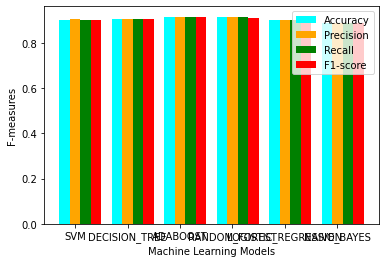

In [21]:
# importing package
import matplotlib.pyplot as plt
import numpy as np
  
# '6' means 6 ML models performance are going to be shown
x = np.arange(6)
width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, accuracies, width, color='cyan')
plt.bar(x, precisions, width, color='orange')
plt.bar(x+0.2, recalls, width, color='green')
plt.bar(x+0.4, f1_scores, width, color='red')

plt.xticks(x, ['SVM', 'DECISION_TREE', 'ADABOOST', 'RANDOM_FOREST', 'LOGISTIC_REGRESSION','NAIVE_BAYES'])
plt.xlabel("Machine Learning Models")
plt.ylabel("F-measures")
plt.legend(["Accuracy", "Precision", "Recall","F1-score"])
plt.show()

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


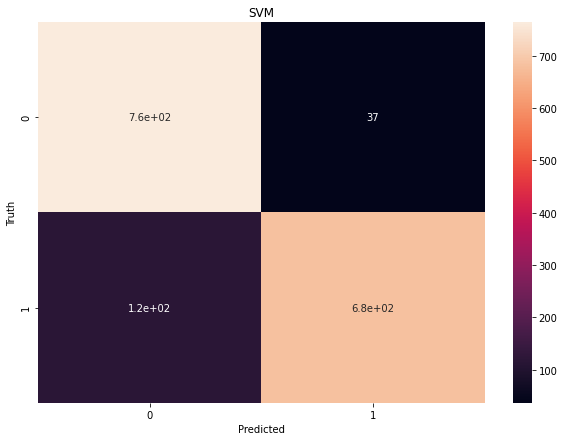

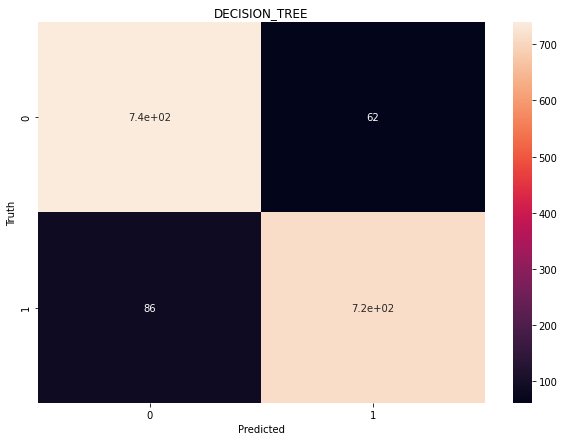

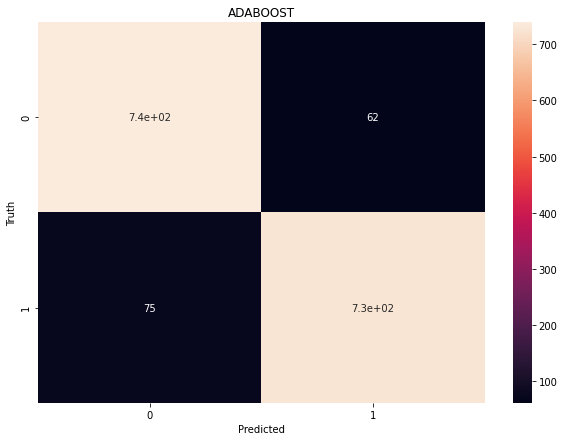

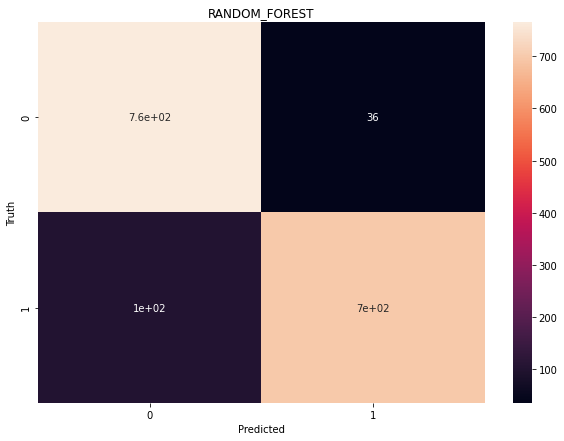

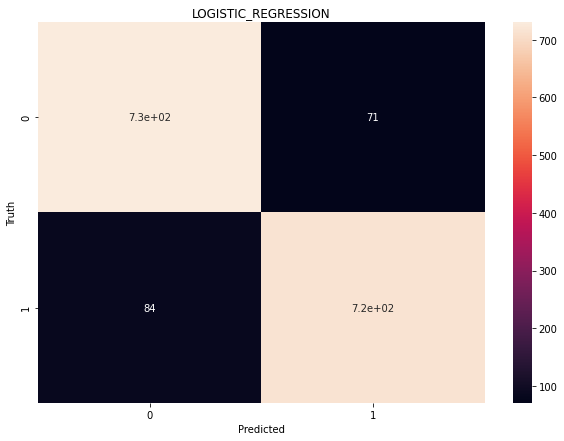

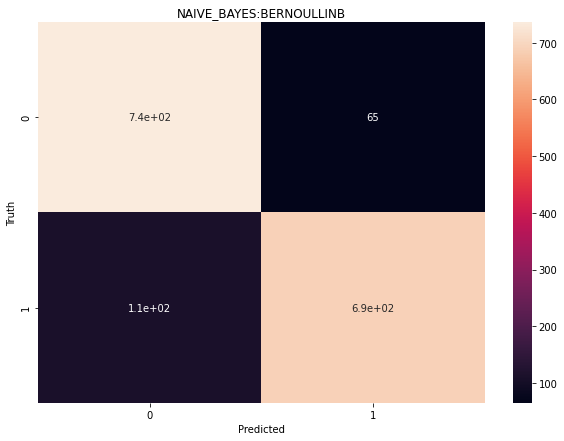

In [23]:
import seaborn as sn
%matplotlib inline
import matplotlib.pyplot as plt

#Confusion matrix of best classification results of the models
for model_name,matrix in ConfusionMatrix.items():
    #print(model_name)
    plt.figure(figsize = (10,7))
    sn.heatmap(matrix, annot=True)
    plt.title(model_name.upper())
    plt.xlabel('Predicted')
    plt.ylabel('Truth')


# TPOT for Automated Machine Learning

##### Reference


*   https://machinelearningmastery.com/tpot-for-automated-machine-learning-in-python/



In [24]:
pip install tpot

     |████████████████████████████████| 92kB 3.9MB/s 
     |████████████████████████████████| 166.7MB 78kB/s 
     |████████████████████████████████| 163kB 49.9MB/s 
  Created wheel for stopit: filename=stopit-1.1.2-cp37-none-any.whl size=11954 sha256=4910906f779fded0d7702d7c1a146a2b2ae42d6d79683be150e88b6f9e7798fb
  Stored in directory: /root/.cache/pip/wheels/3c/85/2b/2580190404636bfc63e8de3dff629c03bb795021e1983a6cc7
Successfully built stopit
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [25]:
import tpot
print('tpot: %s' % tpot.__version__)

tpot: 0.11.7


In [26]:
from sklearn.model_selection import RepeatedStratifiedKFold
from tpot import TPOTClassifier
# define model evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
cv

RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1)

In [29]:

# define search
model = TPOTClassifier( max_time_mins=60, max_eval_time_mins=5,generations=5, population_size=50, cv=cv, scoring='accuracy', verbosity=2, random_state=10, n_jobs=-1)


In [30]:
# perform the search
model.fit(X, Y)
# export the best model
model.export('tpot_sonar_best_model.py')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Generation 1 - Current best internal CV score: 0.9115644409937887

Generation 2 - Current best internal CV score: 0.9121894409937886

Generation 3 - Current best internal CV score: 0.9121894409937886

Generation 4 - Current best internal CV score: 0.9121894409937886

Generation 5 - Current best internal CV score: 0.9121894409937886

Best pipeline: MLPClassifier(input_matrix, alpha=0.1, learning_rate_init=0.001)
